# Dymas micromagnetic software examples
Author: Diego González Chávez  
email : diegogch@cbpf.br


## Permalloy stripes

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#%matplotlib ipympl
np.set_printoptions(precision=3)
#mpl.style.use('default')

#Dymas
import sys
sys.path.append("../")
import dymas 

#Ubermag
import discretisedfield as df
import micromagneticmodel as mm

oe = 1.0E3/(4*np.pi)  # A/m
emu_cm3 = 1E3  # A/m
MHz_Oe = 1E6/oe  # Hz/(A/m)
erg_cm = 1E-7/1E-2  # J/m

ex = np.array([1, 0, 0])
ey = np.array([0, 1, 0])
ez = np.array([0, 0, 1])

In [2]:
#Stripe 1um x 100 um x 50nm

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.018  # Gilbert damping


mesh = df.Mesh(p1=(0, 0, 0), p2=(1E-6, 100E-6, 50E-9), n=(80, 1, 1))

system = mm.System(name='macrospin')
system.energy += mm.Exchange(A=1.3E-11)
system.energy += mm.Demag()
system.energy += mm.Zeeman(H=0*oe*ex)

system.dynamics += mm.Precession(gamma0=gamma0)
system.dynamics += mm.Damping(alpha=alpha)

Ms = 800*emu_cm3  # (A/m)

Hs = np.arange(0,1001,2.5)

In [3]:
system.energy.zeeman.H = 0*ex
system.m = df.Field(mesh, dim=3, value=0.1*ex+1*ey+0.1*ez, norm=Ms)
S = dymas.System.fromUbermagSystem(system)

## Statics

In [4]:
#Calculate all statics

m_eqs = np.zeros((len(Hs), *S.m.shape))
for i, h in enumerate(Hs):
    H_DC = h*oe*ex
    S.H = df.Field(mesh, dim=3, value=H_DC).array[~S.mask]
    dymas.Minimize(S)
    m_eqs[i] = S.m.copy()

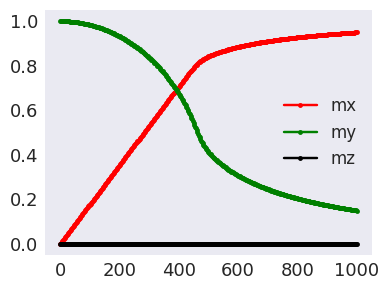

In [5]:
## Plot MxH

plt.close('MxH')
fig = plt.figure('MxH', (4,3))

Mx,My,Mz = m_eqs.mean(axis=1).T

plt.plot(Hs, Mx,  'r.-')
plt.plot(Hs, My,  'g.-')
plt.plot(Hs, Mz,  'k.-')
plt.legend(['mx','my','mz'])
plt.tight_layout()

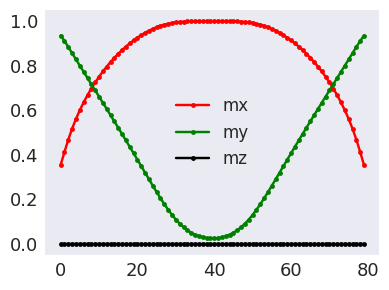

In [6]:
## Plot equibrim state at field Hi
Hi = 500 #Oe
hi = np.abs(Hs - Hi).argmin()

plt.close('M vs Pos')
fig = plt.figure('M vs Pos', (4,3))

Mx,My,Mz = m_eqs[hi].T

plt.plot(Mx, 'r.-')
plt.plot(My, 'g.-')
plt.plot(Mz, 'k.-')
plt.legend(['mx','my','mz'])
plt.tight_layout()


## Dynamics

In [7]:
#Calculate dynamics
mSize = int(S.m.size*2/3)
eig_vals = np.zeros((len(Hs), mSize), dtype='complex')
eig_vects = np.zeros((len(Hs), mSize, mSize), dtype='complex')
Rs = np.zeros((len(Hs), mSize//2, 3, 2))
for i, h in enumerate(Hs):
    H_DC = h*oe*ex
    S.H = df.Field(mesh, dim=3, value=H_DC).array[~S.mask]
    S.m = m_eqs[i].copy()
    dymas.D_operator(S)
    Rs[i] = S.R
    eig_vals[i], eig_vects[i] = np.linalg.eig(S.RD0Rz)

In [8]:
#define sorting functions

def sort_by_freq(eigen_solutions, onlyPositive=False, slice=None):
    vals, vects = eigen_solutions
    f = np.real(vals/(2j*np.pi))
    if onlyPositive:
        sorted_indices = f.argsort()[f[f.argsort()] > 0]
    else:
        sorted_indices = f.argsort()
    if slice is None:
        slice = np.s_[:]
    return vals[sorted_indices][slice], vects[:, sorted_indices][:,slice]


def sort_by_ref(eigen_solutions, reference):
    '''
    Sort eigen_solutions like reference 
    i.e. The eigen_vectors of the same indices are close.
    '''
    vals, vects = eigen_solutions
    ref_vals, ref_vects = reference
    sorted_indices = np.zeros_like(ref_vals, dtype=int)
    for i, _ in enumerate(sorted_indices):
        dprod = np.fromiter((np.vdot(ref_vects[:, i], v) for v in vects.T),
                            np.complex128,
                            count=vects.shape[1])
        # The dot product of the same modes must be close to 1
        sorted_indices[i] = np.argmin(np.abs(np.abs(dprod) - 1))
    return vals[sorted_indices], vects[:,sorted_indices]


In [9]:
# Sort the output modes

f0, v0 = sort_by_freq((eig_vals[0], eig_vects[0]), 
                      onlyPositive=True,
                      slice=np.s_[:40])

vals = np.zeros((len(Hs), *f0.shape), dtype=f0.dtype)
vcts = np.zeros((len(Hs), *v0.shape), dtype=v0.dtype)
vals[0] = f0
vcts[0] = v0

for i in range(1, len(Hs)):
    vals[i], vcts[i] = sort_by_ref((eig_vals[i], eig_vects[i]),
                                   (vals[i-1], vcts[i-1]))
    
frs = np.real(vals/(2j*np.pi))    

Text(14.625000000000002, 0.5, 'Fr (GHz)')

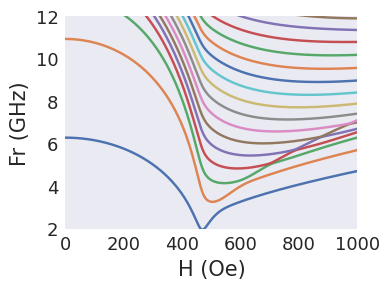

In [10]:
#Plot the dispersionn relation

plt.close('Fr x H')
fig = plt.figure('Fr x H', (4, 3))

for i in range(frs.shape[1])[::2]:
    plt.plot(Hs, np.abs(frs[:, i])/1E9, '-')


plt.ylim(2, 12)
plt.xlim(0, 1000)
plt.ylabel('Freq (GHz)')
plt.xlabel('Field (Oe)')
plt.tight_layout()

plt.xlabel('H (Oe)')
plt.ylabel('Fr (GHz)')

Hr = 0.0 Oe
Fr = 9.205 GHz


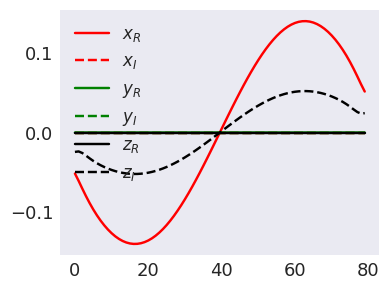

In [11]:
##Plot the eigenvalue reconstructing the 3d vector from the 2d values.

h_test, f_test = (0, 8E9)
hi = np.abs(Hs - h_test).argmin()
print('Hr = %0.1f Oe' % (Hs[hi]))

fs_hi = np.real(eig_vals[hi]/(2j*np.pi))
fi = np.abs(fs_hi - f_test).argmin()
print('Fr = %0.3f GHz' % (fs_hi[fi]/1E9/(1-alpha**2)))

#Get the vector
e_vect_hi_fi = eig_vects[hi, :,fi].reshape(Rs[hi][:,0,:].shape)
mu = np.einsum('xau,xu->xa', Rs[hi], e_vect_hi_fi)

plt.close('Y')
fig = plt.figure('Y', (4, 3))

plt.plot(mu[:, 0].real, 'r-')
plt.plot(mu[:, 0].imag, 'r--')
plt.plot(mu[:, 1].real, 'g-')
plt.plot(mu[:, 1].imag, 'g--')
plt.plot(mu[:, 2].real, 'k-')
plt.plot(mu[:, 2].imag, 'k--')
plt.legend([r'$x_R$', r'$x_I$', r'$y_R$', r'$y_I$', r'$z_R$', r'$z_I$'])
plt.tight_layout()